# Финальное задание курса

В итоговом задании курса мы предлагаем вам решить задачу регрессии - по характеристикам поездок на такси в Нью-Йорке научиться определять их стоимость.

В задании две части:

* первая часть - обычная. Так устроены все ноутбуки с домашними заданиями в курсе. Мы что-то просим - вы делаете. Задания этой части как обычно проверяются тестами на Stepik

* вторая часть - творческая. В этой части мы даем вам лишь идеи того, что можно сделать, а все остальное - на вас. Это задание проверяется в виде текстового отчета (подробности смотрите в описании второй части задания)

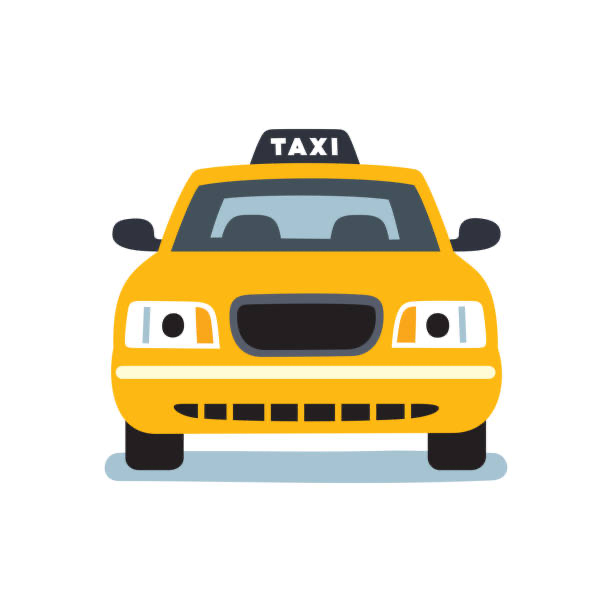

# Импорты

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Часть 1

Считаем данные

In [3]:
df = pd.read_csv("data/final_project_data.csv", parse_dates=['pickup_datetime'])

df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


## Исследование данных

### Quiz

Сколько строк в таблице df?

In [4]:
# ваш код здесь
df.shape[0]

615962

### Quiz

Есть ли пропущенные значения в таблице? В скольких столбцах есть пропуски?

In [5]:
# ваш код здесь
df.columns[df.isna().any()].size

5

### Quiz

Удалите строки с пропущенными значениями из таблицы. Сколько строк осталось в таблице?

In [6]:
# ваш код здесь
df_clear = df.dropna()
df_clear.shape[0]

615959

Удалите из данных колонку `key`, так как в ней дублируется информация из `pickup_datetime`

In [7]:
# ваш код здесь
df_clear = df_clear.drop(columns='key')
df_clear.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


Обработайте колонку `pickup_datetime`. Выделите из нее 4 новых столбца:

* `year` - год поездки
* `month` - месяц поездки
* `day` - день поездки
* `hour` - час поездки. Час вычисляйте так: если до следующего часа осталось меньше 30 минут (на секунды не смотрим), что час округляете до следующего.

Пример: 14:18:20 -> 14 часов, 17:48:29 -> 18 часов

Затем удалите столбец `pickup_datetime`.



In [8]:
# df_clear['pickup_datetime'] = pd.to_datetime(df_clear['pickup_datetime'])

In [9]:
# ваш код здесь
df_clear['year'] = df_clear['pickup_datetime'].dt.year
df_clear['month'] = df_clear['pickup_datetime'].dt.month
df_clear['day'] = df_clear['pickup_datetime'].dt.day

# Получаем минуты и секунды
minutes = df_clear['pickup_datetime'].dt.minute
seconds = df_clear['pickup_datetime'].dt.second

# Определяем, нужно ли округлять час
df_clear['hour'] = df_clear['pickup_datetime'].dt.hour
df_clear.loc[minutes >= 30, 'hour'] += 1
df_clear = df_clear.drop(columns=['pickup_datetime'])

df_clear.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18


## Вопросы по данным

### Quiz

В какие годы совершались поездки?

In [10]:
# ваш код здесь
sorted(df_clear['year'].unique())

[2009, 2010, 2011, 2012, 2013, 2014, 2015]

### Quiz

В какой час было совершено больше всего поездок?

In [11]:
# ваш код здесь
# df_clear['hour'].mode()
# df_clear['hour'].value_counts(ascending=False).head(1)
df_clear['hour'].value_counts().idxmax()

19

### Quiz

В какой сезон (зима, весна, лето, осень) было совершено наименьшее число поездок?

In [12]:
# ваш код здесь
import pandas as p

def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_clear['season'] = df_clear['month'].apply(get_season)

season_counts = df_clear.groupby('season').size().reset_index(name='count')

min_season = season_counts.loc[season_counts['count'].idxmin()]

print("Количество поездок по сезонам:")
print(season_counts)
print(f"\nНаименьшее число поездок было в сезоне: {min_season['season']}")

Количество поездок по сезонам:
  season   count
0  весна  172242
1   зима  153973
2   лето  146371
3  осень  143373

Наименьшее число поездок было в сезоне: осень


In [13]:
df_clear.groupby('season').agg({'passenger_count': 'count'}).rename(columns={'passenger_count': 'count'}).idxmin()

count    осень
dtype: object

In [14]:
df_clear = df_clear.drop('season', axis=1)

In [15]:
df_clear.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18


Постройте scatter plot в осях `pickup_latitude` и `pickup_longitude`

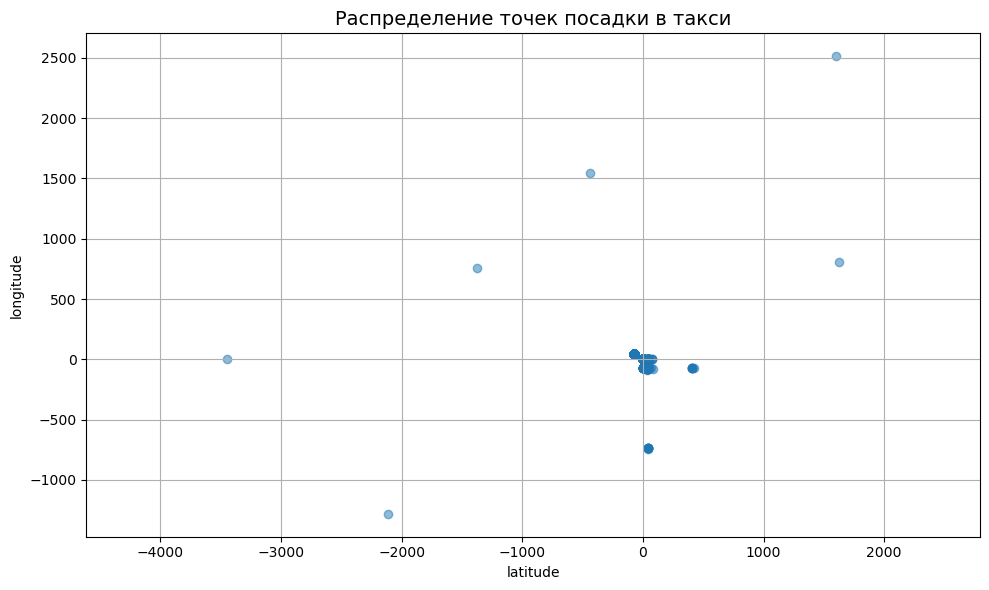

In [16]:
# ваш код здесь
plt.figure(figsize=(10, 6))

plt.scatter(
    x=df_clear['pickup_latitude'],
    y=df_clear['pickup_longitude'],
    alpha=0.5
)

plt.title('Распределение точек посадки в такси', fontsize=14)
plt.xlabel('latitude', fontsize=10)
plt.ylabel('longitude', fontsize=10)
plt.grid(True)
plt.axis('equal')
plt.tight_layout()

plt.show();


### Quiz

Постройте ящик с усами boxplot для `pickup_longitude`. Есть ли на визуализации выбросы? (отдельные точки)

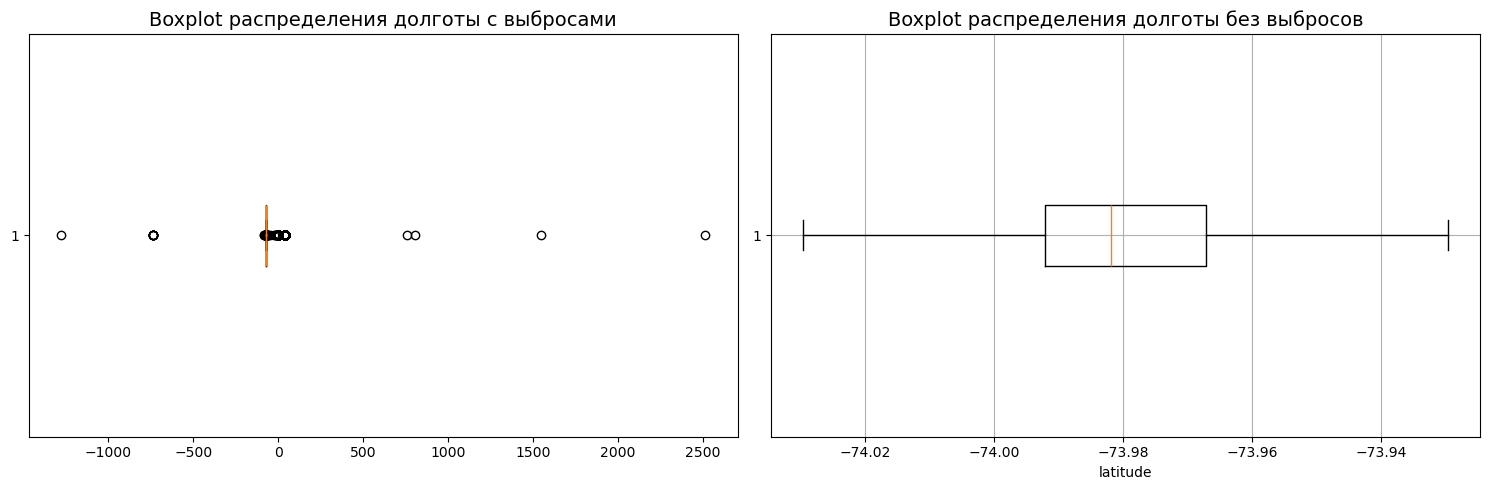

In [17]:
# ваш код здесь
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.boxplot(
    x=df_clear['pickup_longitude'],
    vert=False
)
axes[0].set_title('Boxplot распределения долготы с выбросами', fontsize=14)

ax = axes[1]
ax.boxplot(
    x=df_clear['pickup_longitude'],
    vert=False,
    showfliers=False
)
axes[1].set_title('Boxplot распределения долготы без выбросов', fontsize=14)

plt.xlabel('latitude', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show();

### Quiz

Чему равна медиана `pickup_longitude`? Ответ округлите до тысячных.

In [18]:
# ваш код здесь
round(df_clear['pickup_longitude'].median(), 3)

-73.982

Постройте гистограмму распределения признака `hour`.

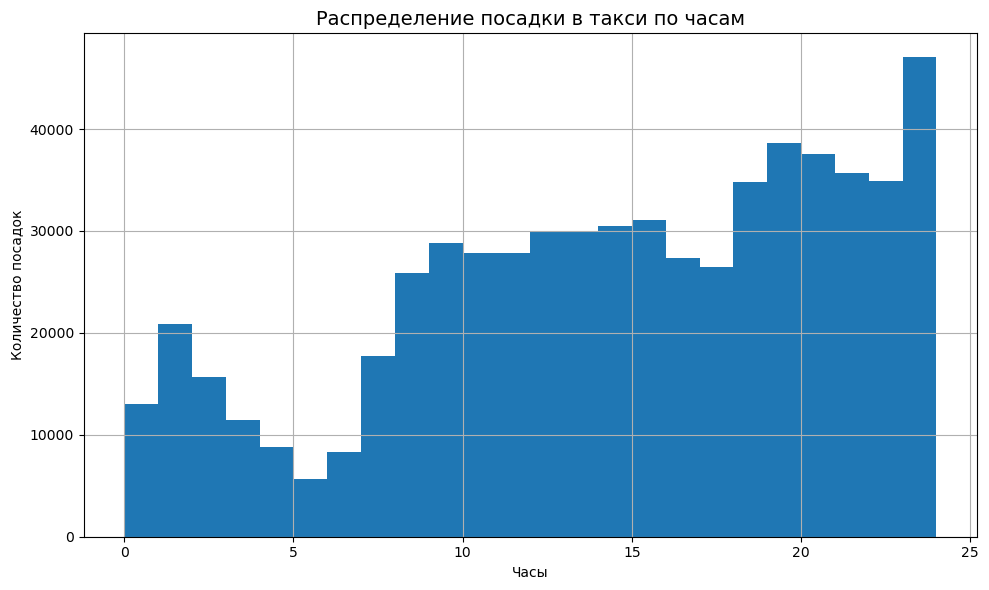

In [19]:
# ваш код здесь
plt.figure(figsize=(10, 6))

plt.hist(
    x=df_clear['hour'],
    bins=24
)

plt.title('Распределение посадки в такси по часам', fontsize=14)
plt.xlabel('Часы', fontsize=10)
plt.ylabel('Количество посадок', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show();


## Построение baseline-модели

Разбейте `df` на матрицу объект-признак `X` и вектор с целевой переменной `y`. Целевая переменная - столбец `fare_amount`.

In [20]:
# ваш код здесь
X = df_clear.drop(columns='fare_amount')
y = df_clear['fare_amount']

Разбейте данные на тренировочную и тестовую части с помощью train_test_split.

Тестовая часть - 25% всех данных, `random_state=42`.

Сколько строк в матрице `X_train`?

In [21]:
# ваш код здесь
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
X_train.shape[0]

461969

### Quiz

Обучите решающее дерево глубины 3 на тренировочных данных и вычислите ошибку $R^2$ на тесте. Ответ округлите до сотых.

Зафиксируйте у дерева `random_state=42`.

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# ваш код здесь
tree = DecisionTreeRegressor(max_depth=3, random_state=42)

tree.fit(X_train, y_train)
predict = tree.predict(X_test)

round(r2_score(y_test, predict), 2)

0.5

### Quiz

Постройте гистограмму важности признаков.

Какой признак имеет наибольший вес?

In [24]:
# ваш код здесь

for i,j in zip(tree.feature_names_in_, tree.feature_importances_):
  print(i, j)

pickup_longitude 0.31174679081699413
pickup_latitude 0.05099006309880093
dropoff_longitude 0.6372631460842049
dropoff_latitude 0.0
passenger_count 0.0
year 0.0
month 0.0
day 0.0
hour 0.0


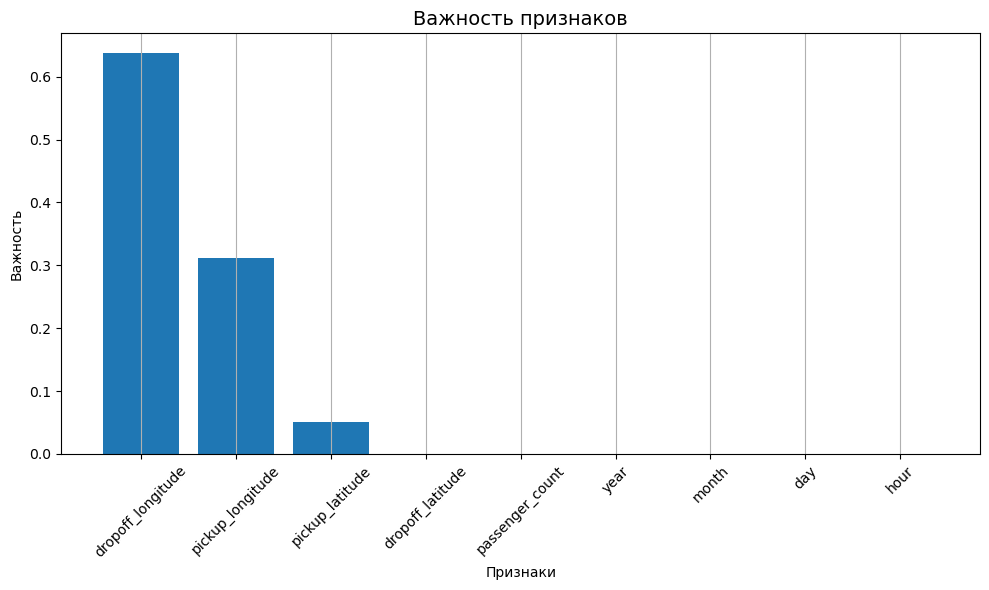

In [25]:
feature_importances_df = pd.DataFrame({'features': X_train.columns,
                                       'feature_importances': tree.feature_importances_})

feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(
    x=feature_importances_df['features'],
    height=feature_importances_df['feature_importances'],
)


plt.title('Важность признаков', fontsize=14)
plt.xlabel('Признаки', fontsize=10)
plt.ylabel('Важность', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()

plt.show();

## Улучшение модели

### Quiz

Постройте гистограмму распределения целевой переменной `y`, укажите параметр `bins=100`.

Является ли распределение нормальным?

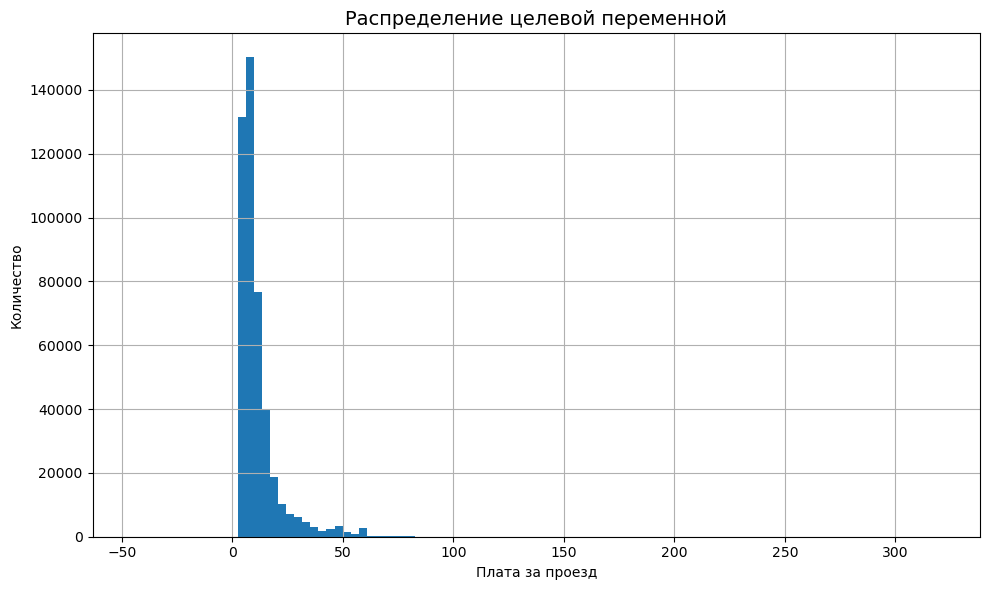

In [26]:
# ваш код здесь
plt.figure(figsize=(10, 6))

plt.hist(
    x=y_train,
    bins=100
)

plt.title('Распределение целевой переменной', fontsize=14)
plt.xlabel('Плата за проезд', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show();


Замените все значения $y$, меньшие 0, на 0.

Сделайте преобразование целевой переменной по правилу $y_{new} = np.log1p(y)$

Заново разбейте данные на тренировочную и тестовую часть по тем же правилам, что и раньше, но теперь используйте `X` и `y_new`.

In [27]:
# ваш код здесь

y_train = y_train.where(y_train >= 0, 0)
y_test = y_test.where(y_test >= 0, 0)

y_train_new = np.log1p(y_train)
y_test_new = np.log1p(y_test)

### Quiz

Заново обучите решающее дерево глубины 3 с `random_state=42` на тренировочных данных и вычислите $R^2$ на тесте. Ответ округлите до сотых.

Перед вычислением $R^2$ сделайте обратное преобразование от прогноза: `np.expm1(pred)` и от `y_test`.

**Важно:** дальше мы будем работать с преобразованной целевой переменной, поэтому при вычислении $R^2$ во всех заданиях ниже делайте обратное преобразование.

In [28]:
# ваш код здесь

tree = DecisionTreeRegressor(max_depth=3, random_state=42)

tree.fit(X_train, y_train_new)
predict = tree.predict(X_test)

round(r2_score(y_test, np.expm1(predict)), 2)

0.44

### Quiz


Подберите по кросс-валидации на тренировочных данных глубину дерева в диапазоне от 3 до 10 включительно с шагом 1 (`random_state=42`).

`cv=3, scoring=r2`

Затем примените модель с оптимальной глубиной на тесте и вычислите $R^2$. Ответ округлите до сотых.

Перед вычислением $R^2$ не забудьте (как и дальше) делать преобразование `np.expm1`

In [29]:
# ваш код здесь
params = {'max_depth': np.arange(3, 11, 1)}

tree = DecisionTreeRegressor(random_state=42)

gs_tree = GridSearchCV(tree, params, cv=3, scoring='r2', n_jobs=-1)

gs_tree.fit(X_train, y_train_new)
predict = gs_tree.predict(X_test)

round(r2_score(y_test, np.expm1(predict)), 2)

0.69

In [30]:
from tqdm import tqdm

best_max_depth = 0
best_score = -np.inf

for max_depth in tqdm(range(3,11), desc='max_depth'):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1))
    if score > best_score:
        best_score = score
        best_max_depth = max_depth
print(f'Лучшая метрика r2 = {best_score} получена при глубине дерева max_depth = {max_depth}')

tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

tree.fit(X_train, y_train_new)
predict = tree.predict(X_test)

round(r2_score(y_test, np.expm1(predict)), 2)

max_depth: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


Лучшая метрика r2 = 0.6765439205596042 получена при глубине дерева max_depth = 10


0.69

## Усложнение пайплайна

Создайте pipeline, в котором сначала извлеките полиномиальные признаки степени 2 из данных, а затем обучите решающее дерево глубины 3 с `random_state=42`.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

p1 = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

### Quiz

Обучите pipeline на тренировочных данных, сделайте прогноз на тесте и вычислите $R^2$. Ответ округлите до сотых.

In [32]:
# ваш код здесь
p1.fit(X_train, y_train_new)
y_pred = p1.predict(X_test)

round(r2_score(np.expm1(y_test_new), np.expm1(y_pred)), 2)

0.42

При помощи GridSearchCV с теми же гиперпараметрами, что и раньше, подберите глубину дерева внутри пайплайна в диапазоне от 3 до 10 включительно с шагом 1.

In [33]:
# ваш код здесь
params = {'model__max_depth': np.arange(3, 11)}

gs_p1 = GridSearchCV(p1, params, cv=3, scoring='r2', n_jobs=-1)

gs_p1.fit(X_train, y_train_new)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features', PolynomialFeatures()),
                                       ('model',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='r2')

### Quiz

Выведите $R^2$ лучшего результата на тесте. Ответ округлите до сотых.

In [34]:
# ваш код здесь
y_pred = gs_p1.predict(X_test)
round(r2_score(np.expm1(y_test_new), np.expm1(y_pred)), 2)

0.72

## Feature selection

Добавьте в предыдущий пайплайн:
* после добавления полиномиальных признаков - StandardScaler
* затем - снижение размерности при помощи метода `SelectFromModel` с моделью `Ridge` с гиперпараметрами по умолчанию.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge

# ваш код здесь
p2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Ridge())),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

Обучите пайплайн на тренировочных данных, сделайте прогноз на тесте и вычислите для него $R^2$.

In [36]:
# ваш код здесь
p2.fit(X_train, y_train_new)
y_pred = p2.predict(X_test)

round(r2_score(np.expm1(y_test_new), np.expm1(y_pred)), 2)

0.44

Подберите глубину решающего дерева в пайплайне, в том же диапазоне и теми же гиперпараметрами GridSearch, что и в предыдущих заданиях.

Вычислите $R^2$ на тестовых данных, ответ округлите до сотых.

In [37]:
# ваш код здесь
params = {'model__max_depth': np.arange(3, 11)}

gs_p2 = GridSearchCV(p2, params, cv=3, scoring='r2', n_jobs=-1)

gs_p2.fit(X_train, y_train_new)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=Ridge())),
                                       ('model',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='r2')

In [38]:
# ваш код здесь
y_pred = gs_p2.predict(X_test)
round(r2_score(np.expm1(y_test_new), np.expm1(y_pred)), 2)

0.71

### Quiz

Удалось ли при помощи пайплайна с отбором признаков улучшить результат предыдущей лучшей модели?

## Кодирование категориальных признаков

Признаки `month`, `day`, `hour` - категориальные (подумайте почему!)

Поэтому их можно попробовать закодировать.

Попробуем подход: группировка значений признака + дальнейшая OneHot-кодировка.

* Создайте колонки `winter`, `spring`, `summer`, `autumn` - в каждую из которых пишите 1, если месяц относится к сезону, и 0 иначе.

* Создайте колонки `start_month`, `middle_month`, `end_month` - в каждую колонку пишите 1, если день относится к началу месяца (1-10 число), середине месяца (11-20 число), концу месяца (от 21 числа), и 0 иначе.

* Создайте колонки `night`, `morning`, `day`, `evening` по аналогии. Если час - от 23 до 5, то это `night`, от 6 до 11 - `morning`, от 12 до 16 - `day`, от 17 до 22 - `evening`.

После создания новых колонок удалите колонки `month`, `day`, `hour`.

P.S. Отдельно делайте преобразования для X_train и для X_test, чтобы заново не разбивать данные.

In [39]:
# ваш код здесь

print(X_train.shape[1])

def get_df_prepared(df):
    season_mapping = {
        (12, 1, 2): 'winter',
        (3, 4, 5): 'spring',
        (6, 7, 8): 'summer',
        (9, 10, 11): 'autumn'
    }
    for season, months in season_mapping.items():
        df[months] = df['month'].apply(lambda x: 1 if x in season else 0)

    df['start_month'] = df['day'].apply(lambda x: 1 if 1 <= x <= 10 else 0)
    df['middle_month'] = df['day'].apply(lambda x: 1 if 11 <= x <= 20 else 0)
    df['end_month'] = df['day'].apply(lambda x: 1 if x >= 21 else 0)

    df['night'] = df['hour'].apply(lambda x: 1 if (x >= 23 or x < 6) else 0)
    df['morning'] = df['hour'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
    df['day_time'] = df['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
    df['evening'] = df['hour'].apply(lambda x: 1 if 17 <= x <= 22 else 0)

    df = df.drop(['month', 'day', 'hour'], axis=1)
    return df

X_train = get_df_prepared(X_train)
X_test = get_df_prepared(X_test)

9


In [40]:
X_train.shape[1]

17

In [41]:
X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,winter,spring,summer,autumn,start_month,middle_month,end_month,night,morning,day_time,evening
157317,-73.957497,40.773888,-73.948975,40.773075,1.0,2015,1,0,0,0,0,0,1,0,0,0,1
196960,-73.978980,40.772448,-74.003533,40.747260,1.0,2012,0,1,0,0,0,0,1,1,0,0,0
464532,-73.983977,40.729296,-73.976709,40.732457,1.0,2013,1,0,0,0,1,0,0,0,0,0,1
412659,-73.960170,40.804518,-73.982100,40.764610,1.0,2011,1,0,0,0,0,1,0,1,0,0,0
227464,-73.981359,40.780897,-73.981001,40.788972,1.0,2011,1,0,0,0,0,1,0,0,0,0,1


### Quiz

На сколько признаков стало больше в матрице-объект признак после добавления закодированных категориальных столбцов и удаления исходных категориальных столбцов?

Подберите при помощи GridSearch с теми же гиперпараметрами, что и выше, оптимальную глубину дерева в диапазоне от 3 до 10 включительно (с шагом 1). У дерева `random_state=42`.

In [42]:
# ваш код здесь
params = {'max_depth': np.arange(3, 11, 1)}

tree = DecisionTreeRegressor(random_state=42)

gs_tree = GridSearchCV(tree, params, cv=3, scoring='r2', n_jobs=-1)

gs_tree.fit(X_train, y_train_new)
predict = gs_tree.predict(X_test)

round(r2_score(y_test, np.expm1(predict)), 2)

0.68

Постройте гистограмму важности признаков для полученной модели (лучшей по GridSearch).

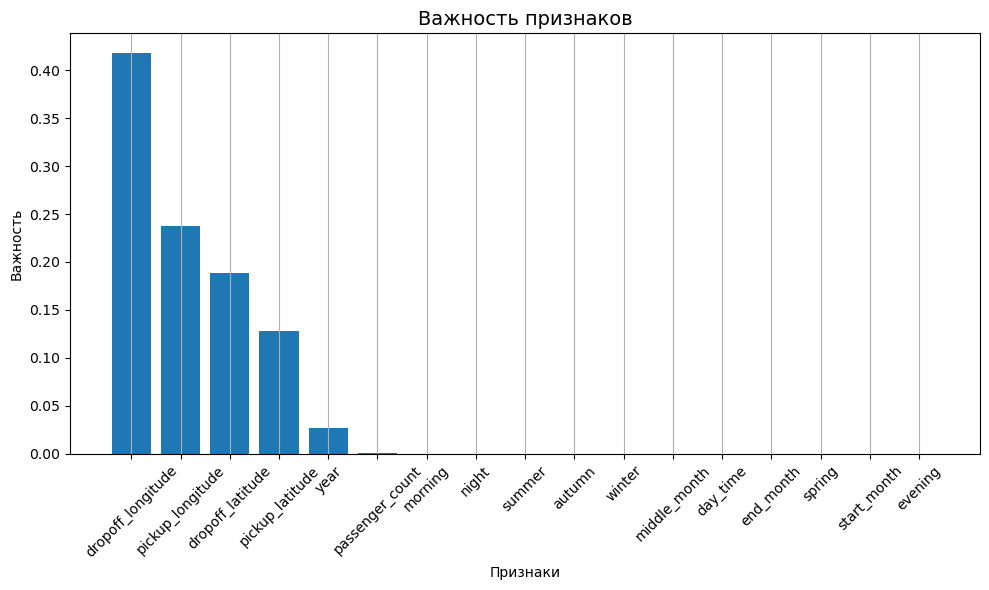

In [43]:
# ваш код здесь
feature_importances_df = pd.DataFrame({'features': X_train.columns,
                                       'feature_importances': gs_tree.best_estimator_.feature_importances_})

feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(
    x=feature_importances_df['features'],
    height=feature_importances_df['feature_importances'],
)


plt.title('Важность признаков', fontsize=14)
plt.xlabel('Признаки', fontsize=10)
plt.ylabel('Важность', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()

plt.show();

### Quiz

Какой из признаков, связанных с датой поездки, самый важный для модели?

## Кластеризация и визуализация

Оставьте только те строчки в таблице df (после удаления пропусков), для которых выполнены оба условия:

* `dropoff_latitude` $\in (39;41)$
* `dropoff_longitude` $\in (-75;-72)$

### Quiz

Сколько строк осталось в таблице?

In [44]:
# ваш код здесь
filtered_df = df_clear.loc[
    (df_clear['dropoff_latitude'].between(39, 41)) &
    (df_clear['dropoff_longitude'].between(-75, -72))
]
filtered_df.shape[0]

603729

Разбейте все поездки по признакам `dropoff_latitude`, `dropoff_longitude` на 5 кластеров.

Используйте kmeans c `random_state=42`.

Визуализируйте поездки из таблицы df в осях `dropoff_latitude`, `dropoff_longitude` - покрасьте точки в цвета, соответствующие кластерам.

In [45]:
# ваш код здесь
kmeans = KMeans(n_clusters=5, random_state=42)

filtered_df['cluster'] = kmeans.fit_predict(filtered_df[['dropoff_latitude', 'dropoff_longitude']])
filtered_df.head()

c:\Users\Pong\anaconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Pong\anaconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\Pong\AppData\Local\Temp\ipykernel_3016\1963651835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster'] = kmeans.fit_predict(filtered_df[['dropoff_lat

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,cluster
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15,1
1,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22,1
2,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18,0
3,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15,4
4,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18,0


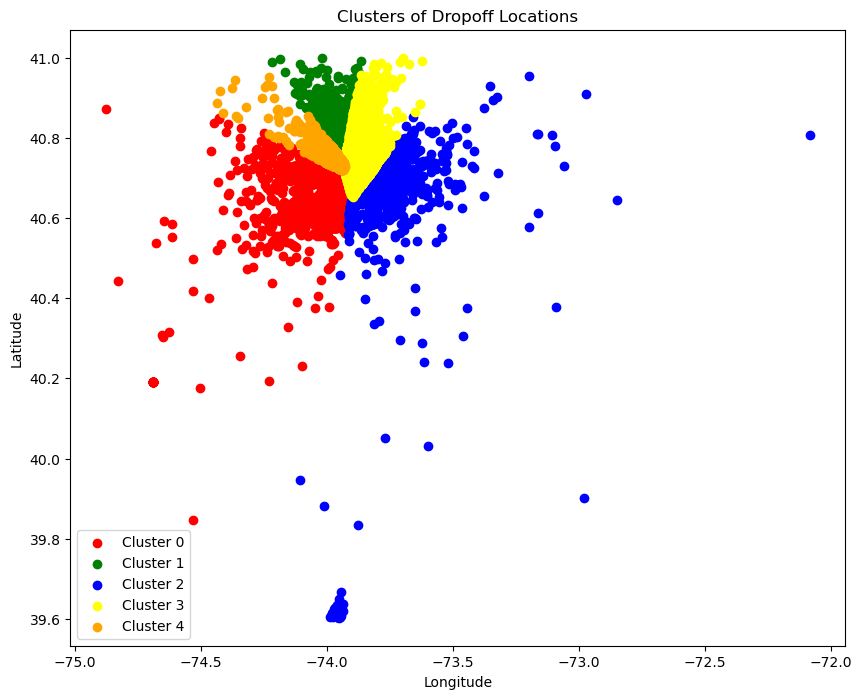

In [46]:
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'yellow', 'orange']
for i in range(5):
    cluster_data = filtered_df[filtered_df['cluster'] == i]
    plt.scatter(cluster_data['dropoff_longitude'], cluster_data['dropoff_latitude'], c=colors[i], label=f'Cluster {i}')
plt.title('Clusters of Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show();

### Quiz

Для каждого кластера вычислите среднюю стоимость поездки.

Чему равна самая большая средняя стоимость поездки по кластерам? Ответ округлите до целого числа.

In [47]:
# ваш код здесь
filtered_df.groupby('cluster')['fare_amount'].mean().sort_values(ascending=False).round()

cluster
2    40.0
3    24.0
0    13.0
1    10.0
4    10.0
Name: fare_amount, dtype: float64

Отдельно нарисуйте кластер с наибольшей средней стоимостью поездки. В нем выделяется два островка.

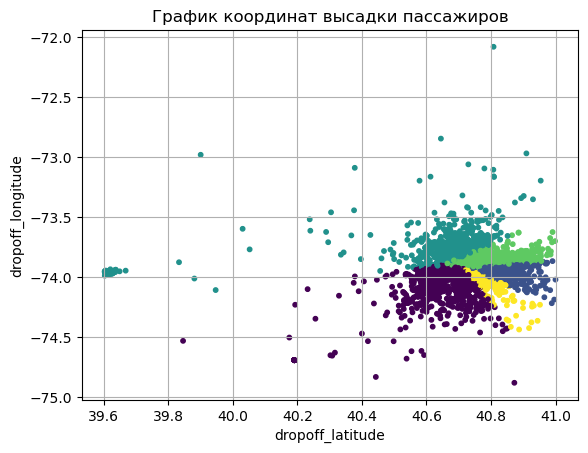

In [48]:
# ваш код здесь
plt.scatter(filtered_df['dropoff_latitude'], 
            filtered_df['dropoff_longitude'], 
            c = kmeans.labels_, 
            s=10, 
            cmap='viridis'
           )
plt.title('График координат высадки пассажиров')
plt.xlabel('dropoff_latitude')
plt.ylabel('dropoff_longitude')
plt.grid('all')

plt.show();

### Quiz

Кластеризуйте точки этого кластера при помощи DBSCAN с гиперпараметрами `eps`=0.15, `min_samples`=10.

Нарисуйте результат.

Вычислите координаты центра (среднее арифметрическое) меньшего кластера.

В ответе укажите `dropoff_latitude`, округленную до тысячных.

C:\Users\Pong\AppData\Local\Temp\ipykernel_3016\1035876911.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['km_clusters'] = kmeans.labels_


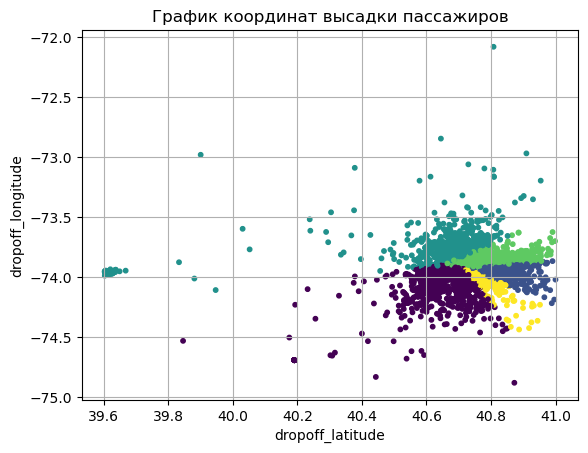

In [49]:
X = df[(df['dropoff_latitude'] > 39) & 
   (df['dropoff_latitude'] < 41) & 
   (df['dropoff_longitude'] > -75) & 
   (df['dropoff_longitude'] < -72)
  ]

X_train = X[['dropoff_latitude', 'dropoff_longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)

X['km_clusters'] = kmeans.labels_
X.groupby(by='km_clusters')['fare_amount'].mean().sort_values(ascending=False)



plt.scatter(X['dropoff_latitude'], 
            X['dropoff_longitude'], 
            c = kmeans.labels_, 
            s=10, 
            cmap='viridis'
           )
plt.title('График координат высадки пассажиров')
plt.xlabel('dropoff_latitude')
plt.ylabel('dropoff_longitude')
plt.grid('all')
plt.show();

(7031, 9)


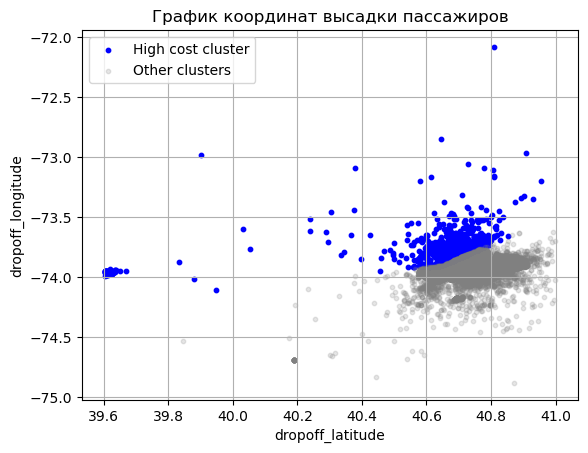

In [50]:
# Найдем значение кластера с наибольшей средней стоимостью поездки
high_cluster = X.groupby(by='km_clusters')['fare_amount'].mean().sort_values(ascending=False).index[0]

# Разобьем датасет на 2 части: с наибольшей средней стоимостью поездки и остальные
X_high_cluster = X[X['km_clusters'] == high_cluster]
other_clusters = X[X['km_clusters'] != high_cluster]
print(X_high_cluster.shape)

# Построим кластеры на одном плоте
plt.scatter(X_high_cluster['dropoff_latitude'], 
            X_high_cluster['dropoff_longitude'], 
            s=10,
            c='blue',
            label='High cost cluster'
           )

plt.scatter(other_clusters['dropoff_latitude'], 
            other_clusters['dropoff_longitude'], 
            s=10,
            c='grey',
            alpha=0.2,
            label='Other clusters'
           )
plt.title('График координат высадки пассажиров')
plt.xlabel('dropoff_latitude')
plt.ylabel('dropoff_longitude')
plt.grid('all')
plt.legend()
plt.show()

In [51]:
# ваш код здесь
from sklearn.cluster import DBSCAN

eps = 0.15
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels = dbscan.fit_predict(X_train)

unique_labels = np.unique(labels)
cluster_sizes = [np.sum(labels == label) for label in unique_labels]
smaller_cluster_label = unique_labels[np.argmin(cluster_sizes)]
smaller_cluster_data = X_train[labels == smaller_cluster_label]

MemoryError: 

In [ ]:
center_latitude = smaller_cluster_data['dropoff_latitude'].mean()
center_longitude = smaller_cluster_data['dropoff_longitude'].mean()
round(center_latitude, 3), round(center_longitude, 3)

# Часть 2

## Творческая (но обязательная) часть

В работе мы построили baseline-модель, потом попытались ее улучшить, усложнив пайплайн увеличением, а затем снижением размерности. Но попробовали мы лишь малую часть из всех возможных подходов, а также всего лишь одну модель - решающее дерево.

В этой части задания вам предлагается не ограничивать себя идеями, попробованными выше:
* придумывайте новые признаки
* пробуйте разные кодировки признаков
* снижайте размерность и делайте отбор признаков
* пробуйте разные модели
* комбинируйте подходы

У вас есть знания целого курса для работы над задачей, ни в чем вас не ограничиваем!

Ваша цель - построить модель, дающую наилучший скор $R^2$ на тестовых данных (с фиксированным разбиением на train-test, указанным в коде ноутбука выше).

In [ ]:
# ваш код здесь

### Итоговый отчет

Результаты исследований, проведенных в творческой части задания, оформите в виде отчета. Отчет - это текстовый документ (желательно, google docs - чтобы мы могли при ревью оставлять в нем комментарии), не ноутбук!

В отчете по пунктам должны быть отражены ваши действия при решении задачи:

1) Какие подходы попробовали - перечислить, описать

2) Какие подходы сработали, какие нет

3) Какой пайплайн дал наилучший результат? Какого качества удалось добиться?

4) Интерпретация важности признаков для наилучшего пайплайна. Какие признаки оказались наиболее важны для модели, какие нет? Как вы думаете почему?

Отчет пишется в свободной форме. В отчет можно включать визуализации, если считаете нужным.

Удачи!